**Install dependencies:** In case this notebook is not running [Carto-Lab Docker](https://cartolab.theplink.org/), the cell below aims to install the needed packages for this notebook. If packages are already available, they will be ignored.

In [1]:
import sys
pyexec = sys.executable
print(f"Current Kernel {pyexec}")
!../py/modules/pkginstall.sh "{pyexec}" myst-nb owslib geopandas matplotlib lxml rasterio dotenv

Current Kernel /opt/conda/envs/worker_env/bin/python3.13
myst-nb already installed (version 1.2.0).
owslib already installed (version 0.33.0).
geopandas already installed (version 1.0.1).
matplotlib already installed (version 3.10.1).
lxml already installed (version 5.4.0).
rasterio already installed (version 1.4.3).
dotenv already installed (version unknown).


# Data Retrieval: IOER Monitor


```{admonition} Summary
:class: hint

In this section, we will retrieve and visualize spatial data from the IOER Monitor.

```

In this section, we retrieve spatial data from the IOER Monitor using the Web Coverage Service (WCS). Specifically, we will access the indicator "Percentage of built-up settlement area and transport space to reference area" (Anteil baulich geprägter Siedlungs- und Verkehrsfläche an Gebietsfläche). This indicator describes the proportion of built-up settlement and transport space in an administrative territory and correlates with soil sealing and open space availability (IOER Monitor 2025).

The IOER Monitor data can be previewed in the [geo viewer](https://monitor.ioer.de/?raeumliche_gliederung=raster&zoom=7&lat=51.32717923968566&lng=10.458984375000002&time=2023&ind=S12RG&language=en). The necessary WFS and WCS URLs, along with the unique indicator code (`S12RG`), can be found under <kbd>Export</kbd> → <kbd>OGC Services</kbd>. 



```{figure} ../resources/094_Verdichtung.jpg
:name: 094_Verdichtung
:figclass: fig-no-shadow

Densification of the block development in Berlin Friedrichshain. Photo: Jürgen Hohmuth.
```



## Accessing IOER Monitor Data

The IOER Monitor allows querying:

- Raster data via [Web Coverage Service (WCS)](https://de.wikipedia.org/wiki/Web_Coverage_Service)
- Vector data via [Web Feature Service (WFS)](https://en.wikipedia.org/wiki/Web_Feature_Service)

To use the API programmatically, you need a personal API key. If you don’t have one yet, refer to the previous section for instructions.

## Retrieving IOER Monitor API in Python 

**Load dependencies**

Before running the workflow, ensure the necessary libraries are installed and imported:

In [2]:
# Standard library imports
import json
import os
import sys
import io
from pathlib import Path
from urllib.parse import urlencode

# Third-party imports
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gp
from IPython.display import display, Markdown
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from owslib.wcs import WebCoverageService
from lxml import etree

Load additional tools module

In [3]:
base_path = Path.cwd().parents[0]
module_path = str(base_path / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import tools

**Define parameters**

To access the IOER Monitor data, we define two key parameters:

- `MONITOR_WCS_BASE`: IOER Monitor API base endpoint
- `IOERMONITOR_WCS_ID`: unique indicator code

In [4]:
MONITOR_WCS_BASE = "https://monitor.ioer.de/monitor_api/user" # API base endpoint
IOERMONITOR_WCS_ID = "S12RG" # Unique indicator code

**Define the base path to store output files in this notebook**

In [5]:
base_path = Path.cwd().parents[0]
OUTPUT = base_path / "out"

**Secure API Key**

To store your API key securely, use a dotenv (`.env`) file. This helps keep sensitive data safe and prevents accidental exposure: 

```{admonition} Alternatively, use <code>getpass()</code>
:class: hint
If you don't want to use an `.env` file, leave this step and you will be asked to directly enter the password in Jupyter below, by using `getpass.getpass()`.
```

1. Create a file named `.env` in the project root. Typically, `.env` files are added to `.gitignore` files to prevent them from being tracked.
2. Add the following line:

   ```
   IOERMONITOR_API_KEY=REPLACE-WITH-YOUR-PASSWORD # replace with your password
   ```

3. Load the key in your script:

In [6]:
from dotenv import load_dotenv
load_dotenv(
    Path.cwd().parents[0] / '.env', override=True)

MONITOR_API_KEY = os.getenv('IOERMONITOR_API_KEY')

```{admonition} You can continue without IOER Monitor Key
:class: hint
See [Notebook 201](content:references:monitorkey) to register your IOER Monitor key. You can continue without an IOER Monitor API key, in which case you will only be able to view cached results below (e.g. for reproduction). If you want to retrieve new data (another region, etc.), register for a trial IOER Monitor key.
```

In [7]:
if MONITOR_API_KEY is None:
    import getpass
    MONITOR_API_KEY = getpass.getpass("Please enter your IOER Monitor API key")
    if not MONITOR_API_KEY:
        # user response empty
        print("Monitor API key not provided. Continuing with cached results..")

Please enter your IOER Monitor API key ········


## Querying WCS Data 

**Configure API request**

(content:references:ioermonitor)=
In order to connect to WCS services from Python, we use `owslib` (see documentation of [owslib.wcs](https://owslib.readthedocs.io/en/latest/usage.html#wcs)).

In [8]:
from urllib.parse import urlencode

params = {
    "id": IOERMONITOR_WCS_ID,
    "key": MONITOR_API_KEY,
    "service": "wcs",
}
wcs_url = f"{MONITOR_WCS_BASE}?{urlencode(params)}"

wcs = WebCoverageService(wcs_url, version="1.0.0") # WCS version `1.0.0`

:::{tip}

When making requests to web APIs, you often need to pass parameters in a URL. However, some characters (such as spaces, special symbols, or non-ASCII characters) can cause issues if they are not properly encoded. `urlencode` prevents character encoding issues and improves readability. For more information, see [urllib.parse module documentation](https://docs.python.org/3/library/urllib.parse.html) 
:::

**Explore Available Data**

Let's first run some checks on the returned `wcs` object and see what data we can access. The data is available for different time intervals and resolutions, as you can see below.

In [9]:
pd.DataFrame(wcs.contents.keys())

0
0      S12RG_2000_100m
1      S12RG_2000_200m
2      S12RG_2000_500m
3     S12RG_2000_1000m
4     S12RG_2000_5000m
..                 ...
103    S12RG_2023_200m
104    S12RG_2023_500m
105   S12RG_2023_1000m
106   S12RG_2023_5000m
107  S12RG_2023_10000m

[108 rows x 1 columns]

Select the dataset for `2023` at `200`m raster resolution, which leads us to the key `S12RG_2023_200m`.

In [10]:
LAYER = 'S12RG_2023_200m'

Check the supported output formats for this layer.

In [11]:
if MONITOR_API_KEY: print(wcs.contents[LAYER].supportedFormats)

['GTiff']


We can also query all additional available metadata for the layer (see dropdown below).

In [12]:
layer_metadata = wcs.contents[LAYER]

print("Available Attributes for the Layer:")
if not MONITOR_API_KEY:
    print("Skipping because API key is not available.")
else:
    for attr in dir(layer_metadata):
        if not attr.startswith("_"):
            try:
                value = getattr(layer_metadata, attr)
                if attr == "descCov":
                    xml_content = etree.tostring(
                        value, pretty_print=True, encoding="unicode")
                    print(f"{attr} (XML Content):\n{xml_content}")
                else:
                    print(f"{attr}: {value}")
            except Exception as e:
                print(f"{attr}: Error accessing attribute - {e}")

Available Attributes for the Layer:
abstract: None
axisDescriptions: []
boundingBox: None
boundingBoxWGS84: (4.93067647168661, 46.8491905772048, 15.9815668414187, 55.5046963165829)
boundingboxes: [{'nativeSrs': 'EPSG:4326', 'bbox': (4.93067647168661, 46.8491905772048, 15.9815668414187, 55.5046963165829)}, {'nativeSrs': 'EPSG:3035', 'bbox': (4000000.0, 2650000.0, 4700000.0, 3600000.0)}]
crsOptions: None
defaulttimeposition: None
grid: <owslib.coverage.wcs100.RectifiedGrid object at 0x7714c64e01a0>
id: S12RG_2023_200m
keywords: []
styles: None
supportedCRS: [urn:ogc:def:crs:EPSG::3035, urn:ogc:def:crs:EPSG::3035]
supportedFormats: ['GTiff']
timelimits: []
timepositions: []
title: S12RG_2023_200m


Check the maximum available boundary for this layer. We can see that the limits are available in two different projections. In the following we will use the projected version of the boundary and not the WGS1984 version.

In [13]:
if MONITOR_API_KEY: print(wcs.contents[LAYER].boundingboxes)

[{'nativeSrs': 'EPSG:4326', 'bbox': (4.93067647168661, 46.8491905772048, 15.9815668414187, 55.5046963165829)}, {'nativeSrs': 'EPSG:3035', 'bbox': (4000000.0, 2650000.0, 4700000.0, 3600000.0)}]


Check the coordinate reference system (CRS).

In [14]:
if MONITOR_API_KEY: print(wcs.contents[LAYER].supportedCRS) # ['EPSG:3035']

[urn:ogc:def:crs:EPSG::3035, urn:ogc:def:crs:EPSG::3035]


**Retrieve and visualize data**

Set up query parameters and request the dataset.

In [15]:
BBOX = None
if MONITOR_API_KEY: BBOX = wcs.contents[LAYER].boundingboxes[1]["bbox"]
CRS = "EPSG:3035"

In [16]:
monitor_param = {
    "identifier": LAYER,
    "bbox": BBOX,
    "resx": 500,
    "resy": 500,
    "crs": CRS,
    "format": "GTiff"
} 
if MONITOR_API_KEY: response = wcs.getCoverage(**monitor_param)

In [17]:
monitor_param

{'identifier': 'S12RG_2023_200m',
 'bbox': (4000000.0, 2650000.0, 4700000.0, 3600000.0),
 'resx': 500,
 'resy': 500,
 'crs': 'EPSG:3035',
 'format': 'GTiff'}

Load and display the GeoTiff with [rasterio](https://rasterio.readthedocs.io/en/stable/). If a cache exist, we prefer to load it directly (instead of querying the API again). If it does not exist, write it.

In [18]:
cache_file = OUTPUT / f"{LAYER}_DE.tiff"

if not cache_file.exists():
    if not MONITOR_API_KEY:
        if not Path(OUTPUT / "S12RG_2023_200m_DE.zip").exists():
            tools.get_zip_extract(
                output_path=OUTPUT,
                uri_filename="https://datashare.tu-dresden.de/s/MjDFj4bxoALa2Hz/download")
    else:
        # write to cache
        with open(cache_file, "wb") as f:
            f.write(response.read())

Visualize response (or cache).

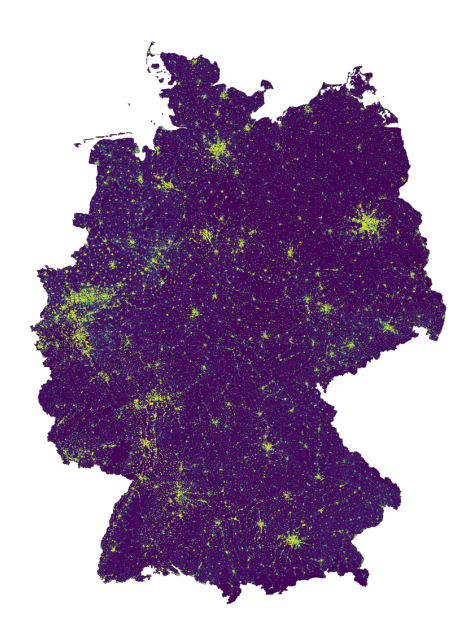

In [19]:
with rasterio.open(cache_file) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)
    ax.axis('off')

## Filtering data for Saxony

However, we want to restrict the raster data to the following boundaries of the state of Saxony, similar to the way we restricted the responses for the GBIF Occurrence API.

1. Reproject the Saxony boundary to `EPSG:3035`.
2. Get boundaries (see section Data Retrieval: GBIF & LAND)
3. Update the monitor parameters (a Python dictionary) with the new `bbox`.
4. Get the grid with the new `bbox` boundary

**Restricting to Saxony boundaries**

Load Saxony boundaries and reproject to match WCS layer.

In [20]:
sachsen_proj = gp.read_file(OUTPUT / 'saxony.gpkg')
BBOX = sachsen_proj.bounds.values.squeeze()
monitor_param["bbox"] = list(map(str, BBOX))

Retrieve and visualize clipped data using `rasterio.show()`.

1. Check and retrieve cache

In [21]:
cache_file = OUTPUT / f"{LAYER}_Saxony.tiff"

if not cache_file.exists():
    if not MONITOR_API_KEY:
        if not Path(OUTPUT / "S12RG_2023_200m_Saxony.zip").exists():
            tools.get_zip_extract(
                output_path=OUTPUT,
                uri_filename="https://datashare.tu-dresden.de/s/Bm74ix6BDQtDzmP/download")
    else:
        # retrieve and write to cache
        response = wcs.getCoverage(**monitor_param)
        with open(cache_file, "wb") as f:
            f.write(response.read())

2. Visualize

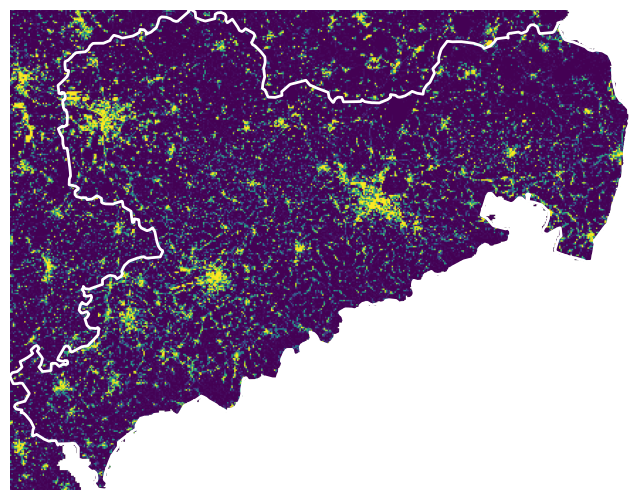

In [22]:
with rasterio.open(cache_file) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)
    sachsen_proj.boundary.plot(
        ax=ax, color='white', linewidth=2)
    ax.axis('off')

**Clipping the raster**

Use `rasterio.mask` to clip the raster with the boundaries of `sachsen_proj`. In addition, the `cmap` (a [Matplotlib Colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html)) is changed to `Reds`.

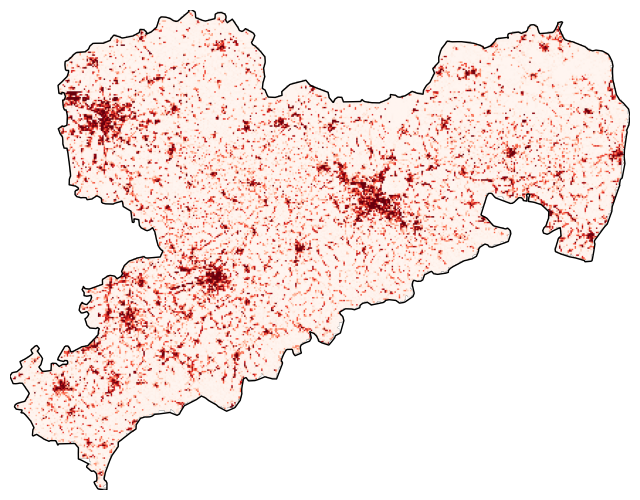

In [23]:
with rasterio.open(cache_file) as src:
    out_image, out_transform = mask(
        src, sachsen_proj.geometry, crop=True, filled=False)
    out_meta = src.meta.copy()
    fig, ax = plt.subplots(
        figsize=(8, 8))
    show(
        out_image, 
        transform=out_transform, 
        ax=ax, cmap='Reds')
    sachsen_proj.boundary.plot(
        ax=ax, color='black', linewidth=1)
    ax.axis('off')

:::{seealso}
For a better understanding of the code, see the [rasterio documentation](https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html).
:::

Save the results to disk as a GeoTIFF. To do this, we first update the clipped raster meta object (`out_meta`) with the transformation information.

In [24]:
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    })

Then use `rasterio.open()` to write the clipped raster.

In [25]:
gtiff_path = OUTPUT / f'saxony_{LAYER}.tif'

with rasterio.open(gtiff_path, "w", **out_meta) as dest:
    dest.write(out_image)

# Get the file size in MB
file_size = gtiff_path.stat().st_size / (1024 * 1024)

print(f"GeoTIFF saved successfully. File size: {file_size:.2f} MB.")

GeoTIFF saved successfully. File size: 0.57 MB.


In [26]:
import sys
from pathlib import Path

module_path = str(Path.cwd().parents[0] / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import tools

root_packages = [
    'python', 'geopandas', 'pandas', 'matplotlib', 'owslib', 'requests', 'rasterio', 'lxml' 'dotenv']
tools.package_report(root_packages)